<a href="https://colab.research.google.com/github/matsonah/ClarkeStatsSpring2022/blob/main/Spring_2022_Module_6_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 6 includes stones 39 through 45 and primarily practices the CI outcome. For those reading the OER text, we are in [Chapter 8](https://openstax.org/books/introductory-statistics/pages/8-introduction). 

Code Block 1: Gathers data

Code Block 2: Chooses data 

Code Block 4: Uses a formula to calculate a confidence interval. 

Code Block 5: 
Bypasses building a population (saves memory) by drawing samples with replacement 100,000 times. The means of those samples make a normal distribution. R uses the Empirical Rule to spit out a confidence interval for where the desired mean actually is. 

Code Block 6: Draws the histogram with boundaries based on Code Block 5. 

Code Block 7: Some notes about calculating sigma. 

In [3]:
#### Code Block 1
gender = read.csv(url("https://gender-pay-gap.service.gov.uk/viewing/download-data/2019"))   #Try out different years
names(gender)
# Read about calculations: https://www.gov.uk/guidance/making-your-gender-pay-gap-calculations#overview 
backup = gender 

[1] "EmployerName"              "EmployerId"               
 [3] "Address"                   "PostCode"                 
 [5] "CompanyNumber"             "SicCodes"                 
 [7] "DiffMeanHourlyPercent"     "DiffMedianHourlyPercent"  
 [9] "DiffMeanBonusPercent"      "DiffMedianBonusPercent"   
[11] "MaleBonusPercent"          "FemaleBonusPercent"       
[13] "MaleLowerQuartile"         "FemaleLowerQuartile"      
[15] "MaleLowerMiddleQuartile"   "FemaleLowerMiddleQuartile"
[17] "MaleUpperMiddleQuartile"   "FemaleUpperMiddleQuartile"
[19] "MaleTopQuartile"           "FemaleTopQuartile"        
[21] "CompanyLinkToGPGInfo"      "ResponsiblePerson"        
[23] "EmployerSize"              "CurrentName"              
[25] "SubmittedAfterTheDeadline" "DueDate"                  
[27] "DateSubmitted"

In [6]:
#### Code Block 2 
# Pick a column. 
gender$column = gender$FemaleUpperMiddleQuartile 
length(gender$column)

[1] 6955

We have a sample from a population. We'd like to use that sample to statistically infer something about the population. 

The gist of the matter:


*   We assume the sample is representative. 
*   That means the population is pretty close to very many copies of the sample. 
*   Make copies of the sample to simulate the population. This is called boot strapping. 
*   Take samples from that boot strapped population to see the range of statistics gathered. 



In [12]:
#### Code Block 3

data= gender$column
z_conf = 0.95
x.bar = mean(data)  #or median(data).


### This part is automated.
sample.size = length(data)
stdev = sd(data)
z.star = qnorm(z_conf) 
margin.of.error = abs(z.star)*(stdev/sqrt(sample.size))  # Formula from text
lower.bound = x.bar - margin.of.error
upper.bound = x.bar + margin.of.error
cat(sep="","At a confidence level of ", z_conf*100, 
      "%, the actual mean of the population is between ", 
      lower.bound," and ", upper.bound, ".\n")  #use floor and ceiling functions if whole numbers make more sense. 

cat(sep="", "With a confidence level of ", z_conf*100, "%, the actual population paramater is approximately ", x.bar, " with a margin of error of ", margin.of.error, ".\n")


At a confidence level of 95%, the actual mean of the population is between 45.29759 and 46.31288.
With a confidence level of 95%, the actual population paramater is approximately 45.80523 with a margin of error of 0.5076484.


Bypass the building of a fake population by drawing a sample with replacement. 

In [10]:
#### Code Block 4
### Warning: If your size is big, this block will take a while. (e.g., sample size = 6,955 -> run time = 41 seconds)
data<-0

data = gender$column 
z_conf=0.95 



## This part is automated.

alpha = 1-z_conf 
zsc=qnorm(z_conf + alpha/2)

size=length(data)
cat("Sample size:", size, "observational units.\n")

test <- 0
test_runs = 100000
for(i in 1:test_runs){
  test[i] = mean( sample(data,size,replace=TRUE))
  }

cat("Original sample statistic is an average of", mean(data),"units with a standard deviation of", sd(data), "units.\n")

Boot = data.frame(x=test)
Boot_mean = mean(Boot$x)
Boot_sd = sd(Boot$x)
Boot_left=Boot_mean - zsc*Boot_sd
Boot_right=Boot_mean + zsc*Boot_sd 
Boots=c(Boot_left,Boot_right)

cat(sep="", "With a confidence level of ", z_conf*100, "%, the actual population paramater is between ", Boot_left, " and ", Boot_right, ".\n")
cat(sep="", "With a confidence level of ", z_conf*100, "%, the actual population paramater is approximately ", Boot_mean, " with a margin of error of ", zsc*Boot_sd, ".\n")


Sample size: 6955 observational units.
Original sample statistic is an average of 45.80523 units with a standard deviation of 25.73857 units.
With a confidence level of 95%, the actual population paramater is between 45.20042 and 46.41106.
With a confidence level of 95%, the actual population paramater is approximately 45.80574 with a margin of error of 0.6053179.


With a confidence level of 95%, the actual population paramater is between 45.20481 and 46.4113.
With a confidence level of 95%, the actual population paramater is approximately 45.80805 with a margin of error of 0.6032455.


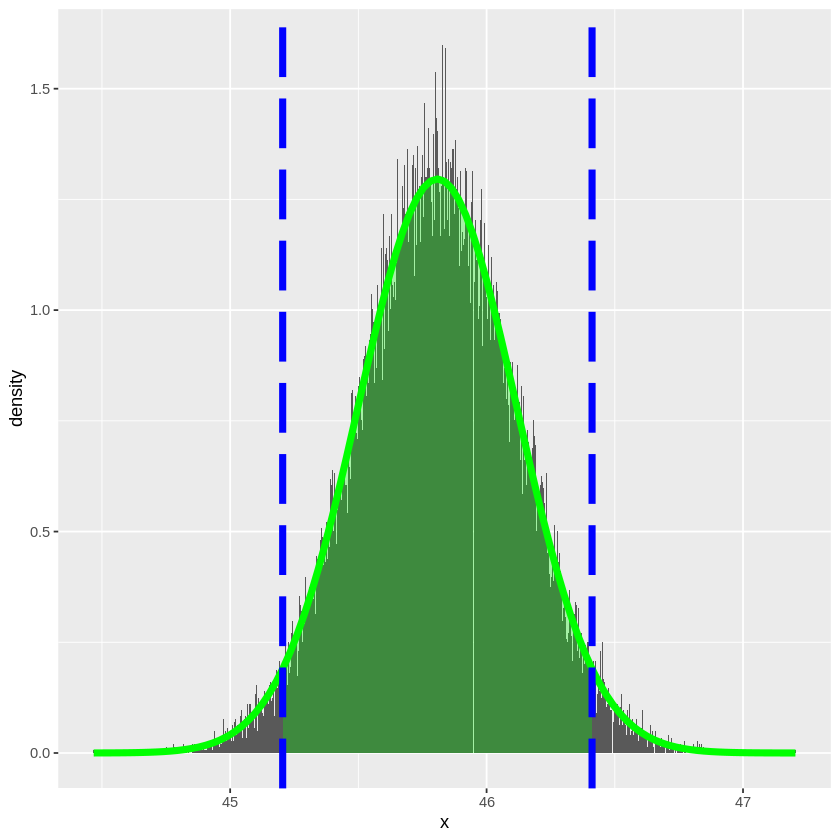

In [9]:
#### Code Block 4
# Requires running Code Block 3
library(ggplot2)

# Fancy function defined to allow for shading. 
dnorm_sd <- function(x,numsd){
  norm_sd <- dnorm(x,Boot_mean, Boot_sd)
  lb = Boot_mean - numsd*Boot_sd  #left bound 
  rb = Boot_mean + numsd*Boot_sd  #right bound 
  # Force NA values outside interval x in [leftbound, rightbound]:
  norm_sd[x <= lb | x >= rb] <- NA
  return(norm_sd)   #return is the result of the function dnorm_sd 
}

width = (max(data)-min(data))/(10*length(data))

ggplot( Boot, aes(x)) + 
  geom_histogram(aes(y=..density..),binwidth=width) +   #change bindwidth to be nice.
  stat_function( fun=dnorm,    args=list(mean=Boot_mean, sd=Boot_sd), col="green", size=2) +
  stat_function( fun=dnorm_sd, args=list(numsd=zsc),  geom="area",  fill="green", alpha=0.3 ) + 
  geom_vline( xintercept=Boots,  linetype="longdash",  col="blue", size=2) 

cat(sep="", "With a confidence level of ", z_conf*100, "%, the actual population paramater is between ", Boot_left, " and ", Boot_right, ".\n")
cat(sep="", "With a confidence level of ", z_conf*100, "%, the actual population paramater is approximately ", Boot_mean, " with a margin of error of ", zsc*Boot_sd, ".\n")

In [ ]:
### Code Block 6
data = gender$column 

M_data = mean(data)
size_data = length(data) 
Dev_data = data - M_data 
Dev_data2 = Dev_data*Dev_data
sigma=sqrt(sum(Dev_data2/size_data))  #STDEV.P in Excel 
sigma_xl = sqrt(sum(Dev_data2/(size_data - 1)))  #STDEV in Excel 
cat("Calculated sigma type 1:", sigma, "Excel calculated sigma:", sigma_xl, "& R sigma:", sd(data))    


Calculated sigma type 1: 517.3995 Excel calculated sigma: 558.8553 & R sigma: 558.8553